In [1]:
# import all relevant libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

import wfdb
from wfdb import processing


# assign the correct path to downloaded data and filenames
# realpath is this script path, while data is subfolder in the same dir
# parent_dir =  os.path.dirname(os.path.realpath(__file__))

parent_dir = os.path.abspath('')
data_dir =  os.path.join(parent_dir,'data')


filenames = []

for i in range(10):
    filenames.append('infant'+str(i+1))

# print and list all relevant filenames, as a quick check
print(parent_dir)
print(data_dir)
print(filenames)

def describe_df(df):
    desc = df.describe()
    desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
    desc.loc['nunique'] = df.nunique()
    desc.loc['count_na'] = df.isna().sum()
    desc.iloc[1:] = desc.iloc[1:].applymap('{:.6f}'.format)
    print(desc)


d:\Github\ecg_resp
d:\Github\ecg_resp\data
['infant1', 'infant2', 'infant3', 'infant4', 'infant5', 'infant6', 'infant7', 'infant8', 'infant9', 'infant10']


In [2]:
df = pd.read_csv(data_dir+'\processed\subsampled{postfix}.csv'.format(postfix='_'+filenames[2]))

# filter data both rows & columns
df = df[20000:100000]
df = df[['hrs', 'resp']]

# add time from index
df['time'] = df.index

# remove outliers
min_hrs = df['hrs'].mean()-3*df['hrs'].std()
max_hrs = df['hrs'].mean()+3*df['hrs'].std()

df = df[(df['hrs']>min_hrs)&(df['hrs']<max_hrs)]

# add unique id everytime hrs change
df['id'] = (df[['hrs']].diff() != 0).cumsum()

# print descriptions of the df
describe_df(df)


                 hrs         resp          time           id
count          79574        79574         79574        79574
mean      117.658771    22.188921  60001.644268  1379.724370
std         4.652027     1.011630  23112.707828   792.265012
min       101.351350    15.739890  20000.000000     1.000000
25%       114.503815    21.615650  39893.250000   698.000000
50%       117.187500    22.086799  60061.500000  1376.000000
75%       120.481926    22.778517  80003.750000  2058.000000
max       133.928570    27.476752  99999.000000  2759.000000
nunique    69.000000  2902.000000  79574.000000  2759.000000
count_na    0.000000     0.000000      0.000000     0.000000


<AxesSubplot:ylabel='resp'>

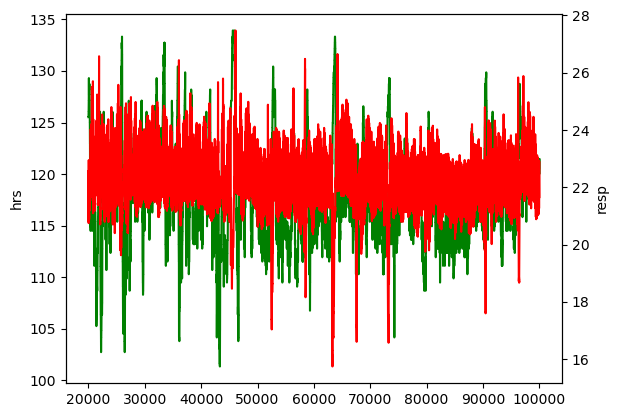

In [3]:
# plot 

sns.lineplot(data=df['hrs'], color="g")
# sns.lineplot(data=df['resp'], color="r")
ax2 = plt.twinx()
# sns.lineplot(data=df['sig'], color="b", ax=ax2)
sns.lineplot(data=df['resp'], color="r", ax=ax2)

In [4]:
%matplotlib inline

import matplotlib.pylab as plt

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

extraction_settings = ComprehensiveFCParameters()

X = extract_features(df[['id', 'time', 'resp']], column_id='id', column_sort='time',
                     default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)

Feature Extraction: 100%|██████████| 30/30 [00:44<00:00,  1.50s/it]


In [5]:
s = pd.Series(range(1,X.shape[0]+1))
dfy = pd.DataFrame({'id': s})
dfy = pd.merge(dfy, df[['hrs', 'id']], on="id", how='outer')
dfy = dfy.drop_duplicates()

dfy

id         hrs
0         1  125.523010
11        2  126.050420
34        3  127.118645
57        4  129.310350
81        5  127.659580
...     ...         ...
79416  2755  119.521910
79441  2756  120.481926
79515  2757  121.457490
79540  2758  120.000000
79565  2759  121.457490

[2759 rows x 2 columns]

In [ ]:
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
  
# Load the data
# dataset = dfr
# # drop = ['hrs', 'sig_min', 'sig_mean', 'sig_max' ]
# y_col = ['hrs']
# X, y =  dataset.drop(columns=y_col), dataset[y_col]

X, y = X, dfy['hrs']
  
# Splitting
train_X, test_X, train_y, test_y = train_test_split(X, y,
                      test_size = 0.3, random_state = 123)


  
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 1000, seed = 123)
  
# Fitting the model
xgb_r.fit(train_X, train_y)
  
# Predict the model
pred = xgb_r.predict(test_X)
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

# r2square compution
r2 = r2_score(test_y, pred)
print("R2 : % f" %(r2))

c:\Users\hafiidz\anaconda3\envs\boost\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:52:31] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  2.794662
R2 :  0.625558


<AxesSubplot:xlabel='y_actual', ylabel='y_pred'>

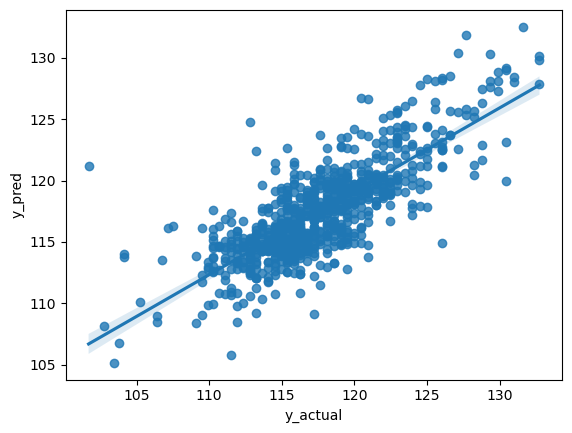

In [ ]:
dft = pd.DataFrame({'y_actual':test_y, 'y_pred': pred})

sns.regplot(data=dft, x='y_actual', y='y_pred')


In [ ]:
df2 = pd.read_csv(data_dir+'\processed\subsampled{postfix}.csv'.format(postfix='_'+filenames[2]))

# filter data both rows & columns
df2 = df2[100000:200000]
df2 = df2[['hrs', 'resp']]

# add time from index
df2['time'] = df2.index

# add unique id everytime hrs change
df2['id'] = (df2[['hrs']].diff() != 0).cumsum()

# print descriptions of the df
describe_df(df2)


X2 = extract_features(df2[['id', 'time', 'resp']], column_id='id', column_sort='time',
                     default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)

s2 = pd.Series(range(1,X2.shape[0]+1))
dfy2 = pd.DataFrame({'id': s2})
dfy2 = pd.merge(dfy2, df2[['hrs', 'id']], on="id", how='outer')
dfy2 = dfy2.drop_duplicates()

dfy2

                 hrs         resp           time           id
count         100000       100000         100000       100000
mean      126.282454    22.251157  149999.500000  1724.380900
std         8.826188     1.105780   28867.657797  1005.144707
min        84.033615    17.117741  100000.000000     1.000000
25%       120.481926    21.615650  124999.750000   855.000000
50%       125.523010    22.085403  149999.500000  1716.000000
75%       130.434780    22.813417  174999.250000  2590.000000
max       214.285720    29.158931  199999.000000  3491.000000
nunique   110.000000  3421.000000  100000.000000  3491.000000
count_na    0.000000     0.000000       0.000000     0.000000


Feature Extraction: 100%|██████████| 30/30 [00:49<00:00,  1.66s/it]


id         hrs
0         1  121.457490
16        2  119.047620
41        3  120.967740
66        4  119.521910
91        5  118.577070
...     ...         ...
99897  3487  123.456790
99921  3488  123.966940
99946  3489  120.481926
99971  3490  118.110240
99996  3491  119.521910

[3491 rows x 2 columns]

RMSE :  2.794662
R2 :  0.158211


<AxesSubplot:xlabel='y_actual', ylabel='y_pred'>

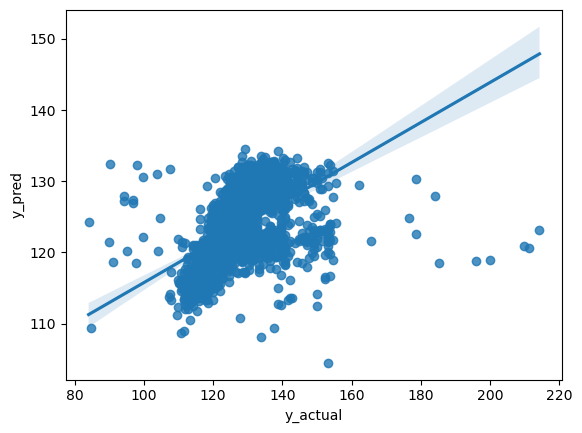

In [ ]:
blind_X, blind_y = X2, dfy2['hrs']

# Predict the model
blind_pred = xgb_r.predict(blind_X)
  
# RMSE Computation
blind_rmse = np.sqrt(MSE(blind_y, blind_pred))
print("RMSE : % f" %(rmse))

# r2square compution
blind_r2 = r2_score(blind_y, blind_pred)
print("R2 : % f" %(blind_r2))


dft = pd.DataFrame({'y_actual':blind_y, 'y_pred': blind_pred})

sns.regplot(data=dft, x='y_actual', y='y_pred')

In [9]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score


# Initialize data
X, y = X, dfy['hrs']
  
# Splitting
train_X, test_X, train_y, test_y = train_test_split(X, y,
                      test_size = 0.3, random_state = 123)


# Initialize CatBoostRegressor
cat = CatBoostRegressor(iterations=20,
                          learning_rate=1,
                          depth=14)
 
# Fitting the model
cat.fit(train_X, train_y)
  
# Predict the model
pred = cat.predict(test_X)
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

# r2square compution
r2 = r2_score(test_y, pred)
print("R2 : % f" %(r2))

c:\Users\hafiidz\anaconda3\envs\boost\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 2.7915656	total: 9.95s	remaining: 3m 9s
1:	learn: 2.4217766	total: 21.2s	remaining: 3m 10s
2:	learn: 2.2513269	total: 24.4s	remaining: 2m 18s
3:	learn: 2.1850774	total: 25.3s	remaining: 1m 41s
4:	learn: 2.0466792	total: 38s	remaining: 1m 53s
5:	learn: 1.9213656	total: 50.1s	remaining: 1m 56s
6:	learn: 1.6882468	total: 1m 2s	remaining: 1m 55s
7:	learn: 1.4437644	total: 1m 14s	remaining: 1m 51s
8:	learn: 1.3197249	total: 1m 26s	remaining: 1m 45s
9:	learn: 1.1283717	total: 1m 38s	remaining: 1m 38s
10:	learn: 1.0449133	total: 1m 50s	remaining: 1m 30s
11:	learn: 0.8858308	total: 2m 3s	remaining: 1m 22s
12:	learn: 0.7664690	total: 2m 15s	remaining: 1m 12s
13:	learn: 0.6209228	total: 2m 28s	remaining: 1m 3s
14:	learn: 0.5477472	total: 2m 40s	remaining: 53.5s
15:	learn: 0.4564326	total: 2m 53s	remaining: 43.3s
16:	learn: 0.3735793	total: 3m 5s	remaining: 32.7s
17:	learn: 0.3053754	total: 3m 17s	remaining: 22s
18:	learn: 0.2587541	total: 3m 29s	remaining: 11s
19:	learn: 0.2160290	tota

<AxesSubplot:xlabel='y_actual', ylabel='y_pred'>

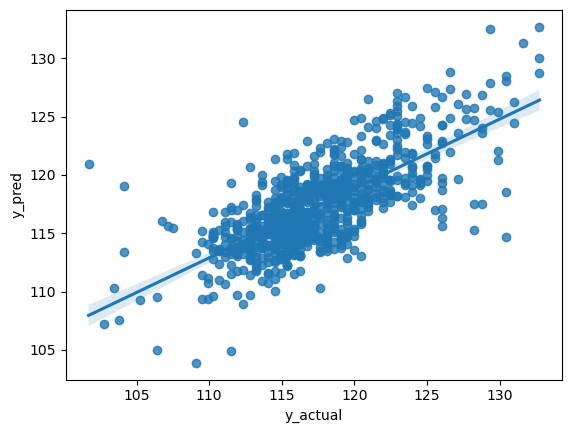

In [11]:
dft = pd.DataFrame({'y_actual':test_y, 'y_pred': pred})

sns.regplot(data=dft, x='y_actual', y='y_pred')